In [1]:
# pip install tscluster

In [2]:
# pip install statsmodels

# Imports

In [3]:
from __future__ import annotations

import re
import time
from itertools import combinations
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import numpy.typing as npt
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from tscluster.tskmeans import TSKmeans
from tscluster.preprocessing.utils import ntf_to_tnf
from tscluster.tsplot import tsplot as tsp

from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import scipy.stats as stats

import difflib


In [4]:
#map(lambda x: x.split('\t'), d.split('\n'))
d = """X
abc 2001
abc	25
def v1
3456
abc v2
def	01
7655"""
d = pd.DataFrame(d.split("\n"))
d.columns = d.iloc[0]
d = d.drop(0, axis=0)
# d = d.astype(int)
d

,X
1,abc 2001
2,abc\t25
3,def v1
4,3456
5,abc v2
6,def\t01
7,7655


In [5]:
for i in d['X']:
    print(i)

abc 2001
abc	25
def v1
3456
abc v2
def	01
7655


In [6]:
# plt.plot(d.iloc[:, 0], d.iloc[:, 1], ls='--', marker='.', color='r', lw=2)
# plt.plot(d.iloc[:, 0], d.iloc[:, 2], ls='--', marker='.', color='g', lw=2)
# plt.plot(d.iloc[:, 0], d.iloc[:, 3], ls='--', marker='.', color='b', lw=2)
# # plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
# plt.hlines(np.arange(0, 41, 10), xmin=0, xmax=5, color='gray', alpha=0.4)
# # plt.xticks([], [])
# # plt.yticks([], [])
# plt.gca().axis('off')
# plt.savefig("example_ts_centriods.png", bbox_inches='tight')
# plt.show()

In [7]:
rand_state = np.random.RandomState(3)
print(rand_state.normal(size=3))
print(rand_state.uniform(low=0, high=10, size=3))
print(rand_state.normal(size=3))

[1.78862847 0.43650985 0.09649747]
[8.92946954 8.96293089 1.2558531 ]
[-1.8634927  -0.46004212 -0.05792084]


In [8]:
# creating a function to create features from lags of multivariate time series
def create_lag_features(arr, n_lags, add_constant):        
    X = []
    
    for i in range(arr.shape[0] - n_lags):
        if add_constant:
            lst = list(arr[i: i+n_lags].T[:, ::-1].flatten()) + [1] # + [1] for constant coefficient
        else:
            lst = arr[i: i+n_lags].T[:, ::-1].flatten()

        X.append(lst) 
            
    return np.array(X)

In [9]:
def create_design_data(X, maxlag, y_col_idx, fit_intercept):
    F = X.shape[1]

    feature_col_mask = np.array([True] * F)
    feature_col_mask[y_col_idx] = False 

    Xi = X[:, feature_col_mask].copy()
    Xi_u = create_lag_features(Xi, maxlag, add_constant=fit_intercept)
    Xi_r = create_lag_features(X[:, [y_col_idx]].copy(), maxlag, add_constant=fit_intercept)

    if fit_intercept:
        Xi_u = np.hstack([Xi_r[:, :-1], Xi_u]) # ensure that the ones for the constant coef is included once.
    else:
        Xi_u = np.hstack([Xi_r, Xi_u])

    yi = X[maxlag:, [y_col_idx]].copy()

    return Xi_u, Xi_r, yi

def cal_local_lr_theta(cov_x_lst, cov_xy_lst):
    return np.matmul(np.linalg.inv(np.sum(np.array(cov_x_lst), axis=0)), np.sum(np.array(cov_xy_lst), axis=0))

def cal_rss(X, y, theta):
    e = y - np.matmul(X, theta)

    return np.matmul(e.T, e).flatten()[0]

def cal_lr(X_u, X_r, y, theta_u, theta_r, scheme, return_rss=False):
    if scheme == 'global':
        total_rss_u = cal_rss(X_u, y, theta_u)
        total_rss_r = cal_rss(X_r, y, theta_r)

        lrs = np.log(total_rss_u) - np.log(total_rss_r)

    elif scheme == 'local':
        lrs = 0
        total_rss_u = 0
        total_rss_r = 0

        for i in range(len(X_u)):
            rss_u = cal_rss(X_u[i], y[i], theta_u)
            rss_r = cal_rss(X_r[i], y[i], theta_r)

            lrs += rss_u - rss_r

            total_rss_u += rss_u
            total_rss_r += rss_r

    if return_rss:
        return lrs, (total_rss_u, total_rss_r)
    
    return lrs

def optimize_theta(
    X: npt.NDArray[np.float64] | npt.NDArray[np.int64],
    maxlag: int,
    scheme: str = 'local',
    y_col_idx: int = -1,
    fit_intercept: bool = True,
    return_rss: bool = False,
    get_model_size: bool = False,
    **kwargs
    ):

    T, N, F = X.shape

    # if y_col_idx == -1:
    #     y_col_idx = F - 1

    X_u_lst = []
    X_r_lst = []
    y_lst = []

    cov_x_u_lst = []
    cov_xy_u_lst = []

    cov_x_r_lst = []
    cov_xy_r_lst = []


    for i in range(N):
        Xi = X[:, i, :].copy()
        
        Xi_u, Xi_r, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=y_col_idx, fit_intercept=fit_intercept)

        X_u_lst.append(Xi_u)
        X_r_lst.append(Xi_r)
        
        y_lst.append(yi)
        
        if scheme == 'local':
            Xi_u_T = Xi_u.T
            Xi_r_T = Xi_r.T

            cov_x_u_lst.append(np.matmul(Xi_u_T, Xi_u))
            cov_xy_u_lst.append(np.matmul(Xi_u_T, yi))
            
            cov_x_r_lst.append(np.matmul(Xi_r_T, Xi_r))
            cov_xy_r_lst.append(np.matmul(Xi_r_T, yi))

    if scheme == 'global' or scheme == 'rss_unrestricted':
        X_u_lst = np.vstack(X_u_lst)
        X_u_lst_T = X_u_lst.T

        cov_x_u_lst.append(np.matmul(X_u_lst_T, X_u_lst))

        y_lst = np.vstack(y_lst)

        cov_xy_u_lst.append(np.matmul(X_u_lst_T, y_lst))

        if scheme != 'rss_unrestricted':
            X_r_lst = np.vstack(X_r_lst)
            X_r_lst_T = X_r_lst.T

            cov_x_r_lst.append(np.matmul(X_r_lst_T, X_r_lst))

            cov_xy_r_lst.append(np.matmul(X_r_lst_T, y_lst))

    theta_u = cal_local_lr_theta(cov_x_u_lst, cov_xy_u_lst)

    if scheme == 'rss_unrestricted':
        return theta_u, cal_rss(X_u_lst, y_lst, theta_u)
    
    theta_r = cal_local_lr_theta(cov_x_r_lst, cov_xy_r_lst)

    results = cal_lr(X_u_lst, X_r_lst, y_lst, theta_u, theta_r, scheme=scheme, return_rss=return_rss)

    if return_rss:
        return theta_u, results[0], theta_r, results[1]
    
    return theta_u, results, theta_r

In [10]:
from collections import Counter

def calculate_purity(labels, clusters):
    """
    Calculate the purity of a clustering result.
    
    Parameters:
    labels (array-like): True class labels.
    clusters (array-like): Cluster assignments.
    
    Returns:
    float: Purity score.
    """
    
    # Total number of data points
    N = len(labels)
    
    # Get unique clusters
    unique_clusters = np.unique(clusters)
    
    # Initialize a counter for correctly assigned points
    correct_assignments = 0
    
    # Loop over each cluster
    for cluster in unique_clusters:
        # Get indices of data points in the current cluster
        cluster_indices = np.where(clusters == cluster)[0]
        
        # Get the true labels of these data points
        cluster_labels = labels[cluster_indices]
        
        # Find the most common class label in the current cluster
        most_common_label, count = Counter(cluster_labels).most_common(1)[0]
        
        # Increment the count of correct assignments
        correct_assignments += count
    
    # Calculate purity
    purity = correct_assignments / N
    
    return purity


In [11]:
def fit_lr_local_model(X, K, maxlag, max_iter, fit_intercept=False, verbose=True, random_state=None):

    N = X.shape[1]

    # km = TSKmeans(K, random_state=42)
    # km.fit(X)
    # labels = km.labels_

    lr_total_prev = np.inf
    C_prev = None
    total_rss_u_prev = None 
    total_rss_r_prev = None
    theta_us_prev = None
    theta_rs_prev = None

    t0 = time.time()
    for iter_ in range(max_iter):
        lr_total = 0
        total_rss_u = 0 
        total_rss_r = 0
        
        # recompute cluster assignment
        C = np.zeros((N, K))

        if iter_ == 0:
            rand_gen = np.random.RandomState(random_state)
            labels = rand_gen.choice(np.arange(K), N)
            
            C[np.arange(N), labels] = 1

            C0 = C.copy()
        
        else:
            for i in range(N):
                Xi = X[:, i, :]
                
                Xi_u, Xi_r, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)
                
                lr_per_j = []

                for j in range(K):
                    rss_u = cal_rss(Xi_u, yi, theta_us[j])
                    rss_r = cal_rss(Xi_r, yi, theta_rs[j])

                    lr_per_j.append(rss_u - rss_r)

                C[i, np.argmin(np.array(lr_per_j))] = 1

        # find best theta per cluster
        theta_us = []
        theta_rs = []

        for j in range(K):
            i_mask = np.argmax(C, axis=1) == j
            X_j = X[:, i_mask, :]
        
            theta_u, lrs, theta_r, rss_ = optimize_theta(X_j, maxlag=maxlag, scheme='local', fit_intercept=fit_intercept, return_rss=True)
        
            lr_total += lrs

            total_rss_u += rss_[0]
            total_rss_r += rss_[1]
            
            theta_us.append(theta_u)
            theta_rs.append(theta_r)
        
        if verbose:
            print(f"Done with {iter_+1} of {max_iter}, lr = {lr_total}, rss_u = {total_rss_u}, rss_r = {total_rss_r}")
        
        if lr_total_prev < lr_total:
            lr_total = lr_total_prev
            total_rss_u = total_rss_u_prev 
            total_rss_r = total_rss_r_prev
            theta_us = theta_us_prev
            theta_rs = theta_rs_prev
            C = C_prev

            break

        lr_total_prev = lr_total
        total_rss_u_prev = total_rss_u
        total_rss_r = total_rss_r_prev
        theta_us_prev = theta_us
        theta_rs_prev = theta_rs
        C_prev = C

    if verbose:
        print()
        print(f"Done after {np.round(time.time() - t0, 2)}secs")

    return theta_us, theta_rs, C, lr_total, total_rss_u, total_rss_r

# global

In [12]:
def fit_lr_model(X, K, maxlag, max_iter, n_init=5, fit_intercept=False, verbose=True, random_state=None):

    rand_gen = np.random.RandomState(random_state)

    results = []
    n_init_falied = False 

    for n in range(n_init):
        if verbose:
            print(f"Started n_init {n+1}/{n_init}")

        N = X.shape[1]

        lr_total_prev = np.inf
        total_rss_u_prev = None 
        total_rss_r_prev = None
        C_prev = None
        theta_us_prev = None
        theta_rs_prev = None

        t0 = time.time()
        for iter_ in range(max_iter):
            lr_total = 0
            total_rss_u = 0 
            total_rss_r = 0

            # recompute cluster assignment
            C = np.zeros((N, K))

            if iter_ == 0:
                labels = rand_gen.choice(np.arange(K), N) #np.array([[i]*10 for i in range(K)]).flatten() 
                
                C[np.arange(N), labels] = 1

                C0 = C.copy()
            
            else:
                for i in range(N):
                    Xi = X[:, i, :]
                    
                    Xi_u, Xi_r, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)
                    
                    lr_per_j = []

                    for j in range(K):
                        rss_u = cal_rss(Xi_u, yi, theta_us[j])
                        rss_r = cal_rss(Xi_r, yi, theta_rs[j])

                        lr_per_j.append(rss_u - rss_r)

                    C[i, np.argmin(np.array(lr_per_j))] = 1

            if any(np.sum(C, axis=0) == 0):
                n_init_falied = True
                results.append((None,)*6)
                break

            # find best theta per cluster
            theta_us = []
            theta_rs = []

            for j in range(K):
                i_mask = np.argmax(C, axis=1) == j
                X_j = X[:, i_mask, :]
            
                theta_u, lrs, theta_r, rss_ = optimize_theta(X_j, maxlag=maxlag, scheme='global', return_rss=True,
                                                    fit_intercept=fit_intercept
                                                    )

                total_rss_u += rss_[0]
                total_rss_r += rss_[1]

                lr_total += lrs

                theta_us.append(theta_u)
                theta_rs.append(theta_r)
            
            if verbose:
                print(f"Done with {iter_+1} of {max_iter}, lr = {lr_total}, rss_u = {total_rss_u}, rss_r = {total_rss_r}")
            
            if lr_total_prev < lr_total:
                lr_total = lr_total_prev
                total_rss_u = total_rss_u_prev 
                total_rss_r = total_rss_r_prev
                theta_us = theta_us_prev
                theta_rs = theta_rs_prev
                C = C_prev

                break

            lr_total_prev = lr_total
            total_rss_u_prev = total_rss_u
            total_rss_r = total_rss_r_prev
            theta_us_prev = theta_us
            theta_rs_prev = theta_rs
            C_prev = C

        if n_init_falied:
            print(f"n_init {n+1} failed due to some empty clusters")
            n_init_falied = False 
        else:
            results.append((theta_us, theta_rs, C, lr_total, total_rss_u, total_rss_r))

        if verbose:
            print()
            print(f"Done after {np.round(time.time() - t0, 2)}secs")

        if verbose:
            print(f"Done with n_init {n+1}/{n_init}")
            print('-'*20)
            print()

    best_init = np.argmin([np.inf if res[3] is None else res[3] for res in results])

    return results[best_init]
	

# Unrestricted Only

In [13]:

# K = 3

# maxlag = 2
# max_iter = 10
# fit_intercept = False 

# N = ts_arr.shape[1]

# # km = TSKmeans(K, random_state=42)
# # km.fit(ts_arr)
# # labels = km.labels_

# rss_total_prev = np.inf
# C_prev = None
# theta_us_prev = None
# # theta_rs_prev = None

# t0 = time.time()
# for iter_ in range(max_iter):
#     rss_total = 0

#     # recompute cluster assignment
#     C = np.zeros((N, K))

#     if iter_ == 0:
#         np.random.seed(1)
#         labels = np.random.choice(np.arange(K), N) #np.array([[i]*10 for i in range(K)]).flatten() 
        
#         C[np.arange(N), labels] = 1

#         C0 = C.copy()
    
#     else:
#         for i in range(N):
#             Xi = ts_arr[:, i, :]
            
#             Xi_u, _, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)
            
#             rss_per_j = []

#             for j in range(K):
#                 rss_u = cal_rss(Xi_u, yi, theta_us[j])
#                 # rss_r = cal_rss(Xi_r, yi, theta_rs[j])

#                 rss_per_j.append(rss_u) # - rss_r)

#             C[i, np.argmin(np.array(rss_per_j))] = 1

#     # find best theta per cluster
#     theta_us = []
#     # theta_rs = []

#     for j in range(K):
#         i_mask = np.argmax(C, axis=1) == j
#         X_j = ts_arr[:, i_mask, :]
    
#         theta_u, rss = optimize_theta(X_j, maxlag=maxlag, scheme='rss_unrestricted', fit_intercept=fit_intercept)
    
#         rss_total += rss

#         theta_us.append(theta_u)
#         # theta_rs.append(theta_r)
    
#     print(f"Done with {iter_+1} of {max_iter}, obj = {rss_total}")
    
#     if rss_total_prev < rss_total:
#         rss_total = rss_total_prev
#         theta_us = theta_us_prev
#         # theta_rs = theta_rs_prev
#         C = C_prev

#         break

#     rss_total_prev = rss_total
#     theta_us_prev = theta_us
#     # theta_rs_prev = theta_rs
#     C_prev = C

# print()
# print(f"Done after {np.round(time.time() - t0, 2)}secs")

In [14]:
def rss_only_model(X, K, maxlag, max_iter, fit_intercept=False, n_init=5, random_state=None, verbose=True):
    rand_gen = np.random.RandomState(random_state)

    results = []
    n_init_falied = False 

    for n in range(n_init):
        if 1:
            print(f"Started n_init {n+1}/{n_init}")
                
        N = X.shape[1]

        rss_total_prev = np.inf
        C_prev = None
        theta_us_prev = None
        # theta_rs_prev = None

        t0 = time.time()
        for iter_ in range(max_iter):
            rss_total = 0

            # recompute cluster assignment
            C = np.zeros((N, K))

            if iter_ == 0:
                rand_gen = np.random.RandomState(random_state)
                labels = rand_gen.choice(np.arange(K), N) #np.array([[i]*10 for i in range(K)]).flatten() 
                
                C[np.arange(N), labels] = 1

                C0 = C.copy()
            
            else:
                for i in range(N):
                    Xi = X[:, i, :]
                    
                    Xi_u, _, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)
                    
                    rss_per_j = []

                    for j in range(K):
                        rss_u = cal_rss(Xi_u, yi, theta_us[j])
                        # rss_r = cal_rss(Xi_r, yi, theta_rs[j])

                        rss_per_j.append(rss_u) # - rss_r)

                    C[i, np.argmin(np.array(rss_per_j))] = 1

            if any(np.sum(C, axis=0) == 0):
                n_init_falied = True
                results.append((None,)*3)
                break

            # find best theta per cluster
            theta_us = []
            # theta_rs = []

            for j in range(K):
                i_mask = np.argmax(C, axis=1) == j
                X_j = X[:, i_mask, :]
            
                theta_u, rss = optimize_theta(X_j, maxlag=maxlag, scheme='rss_unrestricted', fit_intercept=fit_intercept)
            
                rss_total += rss

                theta_us.append(theta_u)
                # theta_rs.append(theta_r)
            
            if verbose:
                print(f"Done with {iter_+1} of {max_iter}, obj = {rss_total}")
            
            if rss_total_prev < rss_total:
                rss_total = rss_total_prev
                theta_us = theta_us_prev
                # theta_rs = theta_rs_prev
                C = C_prev

                break

            rss_total_prev = rss_total
            theta_us_prev = theta_us
            # theta_rs_prev = theta_rs
            C_prev = C

        if n_init_falied:
            print(f"n_init {n+1} failed due to some empty clusters")
            n_init_falied = False 
        else:
            results.append((theta_us, C, rss_total))

        if verbose:
            print()
            print(f"Done after {np.round(time.time() - t0, 2)}secs")

        if verbose:
            print(f"Done with n_init {n+1}/{n_init}")
            print('-'*20)
            print()

    best_init = np.argmin([np.inf if res[2] is None else res[2] for res in results])

    return results[best_init]

# Base Case

In [15]:
def kmeans_b4_modelling(X, K, maxlag, metric='dtw', fit_intercept=False, verbose=True):
    ts_kmeans = TSKmeans(n_clusters=K, metric=metric)
    ts_kmeans.fit(X)
    labels = ts_kmeans.labels_

    if verbose:
        print(f"Labels are {labels}")
    
    N = X.shape[1]

    theta_us = []
    theta_rs = []

    X_u_lst = []
    X_r_lst = []
    y_lst = []

    t0 = time.time()
    for i in range(K):
        cov_x_u_lst = []
        cov_xy_u_lst = []

        cov_x_r_lst = []
        cov_xy_r_lst = []

        Xi = ts_kmeans.cluster_centers_[:, i, :]

        Xi_u, Xi_r, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)

        Xi_u_T = Xi_u.T
        Xi_r_T = Xi_r.T

        cov_x_u_lst.append(np.matmul(Xi_u_T, Xi_u))
        cov_xy_u_lst.append(np.matmul(Xi_u_T, yi))

        cov_x_r_lst.append(np.matmul(Xi_r_T, Xi_r))
        cov_xy_r_lst.append(np.matmul(Xi_r_T, yi))

        theta_us.append(cal_local_lr_theta(cov_x_u_lst, cov_xy_u_lst).flatten())
        theta_rs.append(cal_local_lr_theta(cov_x_r_lst, cov_xy_r_lst).flatten())

        X_u_lst.append(Xi_u)
        X_r_lst.append(Xi_r)
        y_lst.append(yi)

    theta_us = np.array(theta_us)
    theta_rs = np.array(theta_rs)

    C = np.zeros((N, K))

    C[np.arange(N), labels] = 1 

    rss_total = 0

    for j in range(K):
        i_mask = labels == j
        for i in np.arange(N)[i_mask]:

            X_u_j, X_r_j, y_j = create_design_data(X[:, i, :], maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)

            _, rss_ = cal_lr(X_u_j, X_r_j, y_j, theta_us[j].reshape(-1, 1), theta_rs[j].reshape(-1, 1), 
                             scheme='local', return_rss=True)

            rss_total += rss_[0]

    if verbose:
        print(f"Done! rss = {rss_total}")

        print()
        print(f"Done after {np.round(time.time() - t0, 2)}secs")

    return theta_us, C, rss_total

# Most similar coefficient

In [16]:
def most_similar_coef(X, K, maxlag, fit_intercept=False, verbose=True):
    N = X.shape[1]

    theta_us = []
    theta_rs = []

    X_u_lst = []
    X_r_lst = []
    y_lst = []

    t0 = time.time()
    for i in range(N):
        cov_x_u_lst = []
        cov_xy_u_lst = []

        cov_x_r_lst = []
        cov_xy_r_lst = []

        Xi = X[:, i, :]

        Xi_u, Xi_r, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)

        Xi_u_T = Xi_u.T
        Xi_r_T = Xi_r.T

        cov_x_u_lst.append(np.matmul(Xi_u_T, Xi_u))
        cov_xy_u_lst.append(np.matmul(Xi_u_T, yi))

        cov_x_r_lst.append(np.matmul(Xi_r_T, Xi_r))
        cov_xy_r_lst.append(np.matmul(Xi_r_T, yi))

        theta_us.append(cal_local_lr_theta(cov_x_u_lst, cov_xy_u_lst).flatten())
        theta_rs.append(cal_local_lr_theta(cov_x_r_lst, cov_xy_r_lst).flatten())

        X_u_lst.append(Xi_u)
        X_r_lst.append(Xi_r)
        y_lst.append(yi)

    theta_us = np.array(theta_us)
    theta_rs = np.array(theta_rs)

    km_u = KMeans(K)
    km_r = KMeans(K)

    km_u.fit(theta_us[:, :]) # # remove the intercept because they are the same
    km_r.fit(theta_rs[:, :])

    theta_u = km_u.cluster_centers_ #np.hstack([km_u.cluster_centers_, np.ones((K, 1))])
    theta_r = km_r.cluster_centers_ #np.hstack([km_r.cluster_centers_, np.ones((K, 1))])

    labels = km_u.labels_ 
    C = np.zeros((N, K))

    C[np.arange(N), labels] = 1 

    rss_total = 0

    for j in range(K):
        i_mask = np.argmax(C, axis=1) == j
        X_u_j = list(np.array(X_u_lst)[i_mask, :, :])
        X_r_j = list(np.array(X_r_lst)[i_mask, :, :])
        y_j = list(np.array(y_lst)[i_mask, :, :])

        _, rss_ = cal_lr(X_u_j, X_r_j, y_j, theta_u[j].reshape(-1, 1), theta_r[j].reshape(-1, 1), 
                           scheme='local', return_rss=True)
    
        rss_total += rss_[0]

    if verbose:
        print(f"Done! rss = {rss_total}")

        print()
        print(f"Done after {np.round(time.time() - t0, 2)}secs")

    return theta_u, C, rss_total

In [17]:
def avg_coef_distance(true_coef, pred_coef):
    # cal distance matrix
    coef_dist_matrix = []
    for i in range(true_coef.shape[0]):
        coef_dist_matrix.append(np.linalg.norm(true_coef[[i], :] - pred_coef, ord=2, axis=1))

    coef_dist_matrix = np.array(coef_dist_matrix)
    
    cm = coef_dist_matrix.copy()

    # one to one mapping of most similar true to pred such that no two true clusters will map to the same pred
    most_similar_pred = np.zeros(coef_dist_matrix.shape[0], dtype=int)

    for _ in range(cm.shape[0]):
        row, col = np.unravel_index(np.argmin(cm), cm.shape)
        most_similar_pred[row] = col
        cm[:, col] = np.inf
        cm[row, :] = np.inf

    return np.mean(coef_dist_matrix[np.arange(cm.shape[0]), most_similar_pred])

In [18]:
def print_model(theta_us, vars, maxlag, fit_intercept=False, sort_by_weights=False):
    for j in range(len(theta_us)):
        equ_str = f"Cluster {j}: "

        coef_str_lst = []

        theta_j = theta_us[j].flatten()

        if fit_intercept:
            n_par = len(theta_j) - 1
            intercept_str = f"+ {np.round(theta_j[-1], 4)}"
        else:
            n_par = len(theta_j)
            intercept_str = ""
            
        for coef_f in range(n_par):
            var_i, lag_i = np.unravel_index(coef_f, (len(vars), maxlag))

            coef_str_lst.append(f"{np.round(theta_j[coef_f], 4)} {vars[var_i]}_{lag_i+1} ")

        if sort_by_weights:
            coef_str_lst = sorted(coef_str_lst, key=lambda x: np.abs(float(x.split(' ')[0])), reverse=True)
        # coef_str_lst = sorted(coef_str_lst, key=lambda x: -1 * np.abs(float(x.split(' ')[1])))

        else:
            coef_str_lst = sorted(coef_str_lst, key=lambda x: 
                            (x.split(' ')[1].split('_')[0], -1 * int(x.split(' ')[1].split('_')[1])), 
                            reverse=True)
        
        equ_str += " + ".join(coef_str_lst)

        equ_str += intercept_str

        print(equ_str)
        print()
        
        

# Granger Causal Tree

In [19]:
# creating a function to create features from lags of multivariate time series
def create_lag_features(arr, n_lags, add_constant):        
    X = []
    
    for i in range(arr.shape[0] - n_lags + 1):
        if add_constant:
            lst = list(arr[i: i+n_lags].T[:, ::-1].flatten()) + [1] # + [1] for constant coefficient
        else:
            lst = arr[i: i+n_lags].T[:, ::-1].flatten()

        X.append(lst) 
            
    return np.array(X)

In [20]:
def create_design_data_GC(X, maxlag, x_col_idx, fit_intercept):

    Xi = X[:-1, x_col_idx].copy()
    return create_lag_features(Xi, maxlag, add_constant=fit_intercept)

In [21]:
def get_likelihoods(ts_arr, feature_set, maxlag, fit_intercept=True, lambda_reg=0, which='both', return_thetas=False):

    log_likelihoods_u = np.zeros((ts_arr.shape[1], len(feature_set)))
    log_likelihoods_r = np.zeros(ts_arr.shape[1])

    for i in range(ts_arr.shape[1]):
        X = ts_arr[:, i, :]
        
        y = X[maxlag:, [-1]].copy()

        n = X.shape[0]

        if which in ('both', 'unrestricted'):
            for m in range(len(feature_set)):
                p = list(feature_set[m]) + [-1]

                X_u = create_design_data_GC(X, maxlag=maxlag, x_col_idx=p, fit_intercept=fit_intercept)

                b_u = np.matmul(np.linalg.inv(np.matmul(X_u.T, X_u) + lambda_reg * np.identity(X_u.shape[1])), np.matmul(X_u.T, y))                    

                rss_u = np.sum((y - np.matmul(X_u, b_u))**2) + lambda_reg * np.linalg.norm(b_u.flatten())**2
                
                log_likelihoods_u[i, m] = n * np.log(rss_u) 

        # if which in ('both', 'restricted'):
        X_r = create_design_data_GC(X, maxlag=maxlag, x_col_idx=[-1], fit_intercept=fit_intercept)

        b_r = np.matmul(np.linalg.inv(np.matmul(X_r.T, X_r) + lambda_reg * np.identity(X_r.shape[1])), np.matmul(X_r.T, y))

        rss_r = np.sum((y - np.matmul(X_r, b_r))**2) + lambda_reg * np.linalg.norm(b_r.flatten())**2
        
        log_likelihoods_r[i] = n * np.log(rss_r) 
    
    if which == 'unrestricted':
        if return_thetas and len(feature_set) == 1 and ts_arr.shape[1] == 1:
            return log_likelihoods_r[0] - log_likelihoods_u[0], b_u.flatten()

        return log_likelihoods_u
    elif which == 'restricted':
        return log_likelihoods_r 
    return log_likelihoods_u, log_likelihoods_r

In [22]:
def build_tree(i, arr, log_likelihoods_r, feature_set_dict, feature_lst, nodes, maxlag, nodes_to_skip=[], p_value_threshold=None, verbose=False,
               fit_intercept=True, lambda_reg=0):
    df = maxlag
    
    log_likelihoods_u_i = np.zeros(len(feature_set_dict)).astype(float)
    log_likelihoods_u_i[:] = np.nan

    path = []

    min_p_value = np.inf

    for depth_i in range(len(nodes)):
        depth = nodes[depth_i]
        p_values = []
        node_lst = []            

        for node_i in range(len(depth)):
            node = depth[node_i]

            if node in nodes_to_skip:
                continue
           
            # log_likelihood_u = log_likelihoods_u[i, feature_set_dict[node]] 

            if depth_i == 0:
                log_likelihood_r = log_likelihoods_r[i]

                log_likelihood_u = get_likelihoods(arr, [node], maxlag, fit_intercept=fit_intercept, lambda_reg=lambda_reg, which='unrestricted')[0, 0]
                log_likelihoods_u_i[feature_set_dict[node]] = log_likelihood_u

                likelihood_ratio = log_likelihood_r - log_likelihood_u
                p_value = 1 - stats.chi2.cdf(likelihood_ratio, df)

                p_values.append(p_value)
                node_lst.append(node)
                
                if verbose:
                    print(f"depth: {depth}, node: {node}, p_value: {p_value}, lr: {likelihood_ratio}")
            
            else:

                prev_node = path[-1]

                if len(set(node) - set(prev_node)) == 1:

                    log_likelihood_r = log_likelihoods_u_i[feature_set_dict[prev_node]]
                else:
                    continue
                    
                log_likelihood_u = get_likelihoods(arr, [node], maxlag, fit_intercept=fit_intercept, lambda_reg=lambda_reg, which='unrestricted')[0, 0]
                log_likelihoods_u_i[feature_set_dict[node]] = log_likelihood_u
                
                likelihood_ratio = log_likelihood_r - log_likelihood_u
                p_value = 1 - stats.chi2.cdf(likelihood_ratio, df)

                # if prev_node == path[-1]:
                p_values.append(p_value)
                # prev_node_lst.append(prev_node)
                node_lst.append(node)

                if verbose:
                    print(f"depth: {depth}, node: {node}, prev_node: {prev_node}, p_value: {p_value}, lr: {likelihood_ratio}")

        min_idx = np.argmin(p_values)

        if depth_i == 0 or (p_value_threshold is None and p_values[min_idx] < min_p_value):
            path.append(node_lst[min_idx])
            min_p_value = p_values[min_idx]

            if verbose:
                print(path)

        elif p_value_threshold is not None: 
            if p_values[min_idx] < p_value_threshold: # here because we can't do float < None
                path.append(node_lst[min_idx])

            else: # if p_value is not less than threshold
                break 

            if verbose:
                print(path)

        else: # break if threshold is None and p_value not less than min_p_value
            break
        
    return reduce(lambda x, y: x | y, map(set, path)), log_likelihoods_u_i


In [23]:
def GC_PTSC(ts_arr, maxlag, k=None, fit_intercept=True, lambda_reg=0, verbose=False, p_value_threshold=None, use_agg_clustering=False, 
            return_total_models=False):
    N = ts_arr.shape[1]
        
    n_features = ts_arr.shape[2] - 1
    feature_lst = sum([list(combinations(np.arange(n_features), i)) for i in range(1, n_features+1)], [])

    feature_lst_dict = {v: k for k, v in enumerate(feature_lst)}

    nodes = [[p for p in feature_lst if len(p) == i] for i in range(1, n_features + 1)]

    labels = np.zeros(N)
    labels[:] = -1

    important_features = {}

    log_likelihoods_r = get_likelihoods(ts_arr, feature_lst, maxlag, fit_intercept=fit_intercept, lambda_reg=lambda_reg, which='restricted')
    log_likelihoods_u = np.zeros((ts_arr.shape[1], len(feature_lst))).astype(float)
    log_likelihoods_u[:, :] = np.nan
    
    # max_lr_matrix = np.zeros(log_likelihoods_u.shape)
    for i in range(N):
        # important_feature_set, max_lr_arr = build_tree(i, log_likelihoods_u, log_likelihoods_r, feature_lst_dict, nodes, maxlag, 
        #                                                      return_max_lr_arr=True, verbose=verbose)

        important_feature_set, log_likelihoods_u_i = build_tree(i, ts_arr[:, [i], :], log_likelihoods_r, feature_lst_dict, feature_lst, nodes, maxlag, 
                                                             verbose=verbose, p_value_threshold=p_value_threshold, fit_intercept=fit_intercept,
                                                             lambda_reg=lambda_reg)
        
        log_likelihoods_u[i, :] = log_likelihoods_u_i

        important_feature_set = tuple(sorted(list(important_feature_set)))

        if important_feature_set not in important_features:
            important_features[important_feature_set] = int(np.max(labels) + 1)

        labels[i] = important_features[important_feature_set]

        # max_lr_matrix[i, :] = max_lr_arr

    flip_keys_and_values = lambda d: {v: k for k, v in d.items()}
    important_features = flip_keys_and_values(important_features)

    if k is None or len(important_features) == k: # check if there is need to recluster
        if return_total_models:
            return log_likelihoods_r.size + np.sum(~np.isnan(log_likelihoods_u)), log_likelihoods_u.size + log_likelihoods_r.size
        return labels, important_features
    
    elif use_agg_clustering:
        item_sets = list(map(lambda x: important_features[x], labels))

        thetas = np.zeros((N, ts_arr.shape[2]-1))
        for i in range(N):
            node = item_sets[i]
            _, theta = get_likelihoods(ts_arr[:, [i], :], [node], maxlag, fit_intercept=fit_intercept, lambda_reg=lambda_reg, which='unrestricted',
                            return_thetas=True)
            # print(i, node, theta)
            
            thetas[i, list(node)] = np.max(np.abs(theta[: len(node)*maxlag]).reshape(-1, maxlag), axis=1)

        thetas = np.array(thetas)
        km = KMeans(n_clusters=k)
        # km.fit(one_hot_encoded)
        km.fit(thetas)
        labels = km.labels_
        return labels, important_features

    # recluster entities in clusters with low number of entities
    cluster_idx, n_samples_per_cluster = np.unique(labels, return_counts=True) # get entity count of clusters

    sorted_cluster_idx = cluster_idx[np.argsort(n_samples_per_cluster)[::-1]] # sort clusters in descending order of entity count

    clusters = sorted_cluster_idx[:k].copy() # clusters to choose
    nodes_idx_to_keep =  [feature_lst_dict[f] for f in [important_features[j] for j in clusters]] # nodes index to keep
    entities_2_recluster = [i for i in range(N) if labels[i] not in clusters] # enitites to recluster

    # remove clusters with low entity count from the dict
    for j in sorted_cluster_idx[k:]:
        important_features.pop(j)

    important_features = flip_keys_and_values(important_features)

    # get new clusters of the entities without cluster
    for i in entities_2_recluster:
        # important_feature_set = feature_lst[nodes_idx_to_keep[np.argmax(max_lr_matrix[i, nodes_idx_to_keep])]]

        for j in nodes_idx_to_keep:
            if np.isnan(log_likelihoods_u[i, j]):
                log_likelihoods_u[i, j] = get_likelihoods(ts_arr[:, [i], :], [feature_lst[j]], maxlag, fit_intercept=fit_intercept, 
                                                          lambda_reg=lambda_reg, which='unrestricted')[0, 0]
            
        important_feature_set = feature_lst[nodes_idx_to_keep[np.argmax([(log_likelihoods_r[i] - log_likelihoods_u[i, j]) / len(feature_lst[j]) for 
                                                                         j in nodes_idx_to_keep])]]

        # important_feature_set = feature_lst[nodes_idx_to_keep[np.argmin([1 - stats.chi2.cdf(log_likelihoods_r[i] - log_likelihoods_u[i, j], 
        #                                                                                     len(feature_lst[j])*maxlag) for j in nodes_idx_to_keep])]]

        labels[i] = important_features[important_feature_set]

    # renumber cluster index to be in range(k)
    important_features = flip_keys_and_values(important_features)
    new_cluster_labels = sorted(important_features.keys())

    relabeled_important_features = {}
    relabeled_labels = np.zeros(N)
    relabeled_labels[:] = np.nan

    for j, v in enumerate(new_cluster_labels):
        relabeled_important_features[j] = important_features[v]
        relabeled_labels[labels == v] = j 

    if return_total_models:
        return log_likelihoods_r.size + np.sum(~np.isnan(log_likelihoods_u)), log_likelihoods_u.size + log_likelihoods_r.size
    return relabeled_labels, relabeled_important_features

# Cook 

## Census

In [24]:
ts_arr = np.load(r"cook_census_arr_scaled.npy")
ts_arr.shape

(9, 175, 6)

In [25]:
ctuids = np.load('Chicago_zip_codes.npy')
print(ctuids.shape)


(67,)


In [26]:
zip_codes = np.load("cook_zip_codes.npy")
len(zip_codes)

175

In [27]:
chicago_mask = np.isin(zip_codes, ctuids)
chicago_mask

array([False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [28]:
ts_arr = ts_arr[:, chicago_mask, :]
ts_arr.shape

(9, 66, 6)

In [29]:
# bad_idx = []
# for i in range(ts_arr.shape[1]):
#     for f in range(ts_arr.shape[2]):
#         if len(np.unique(ts_arr[:, i, f])) == 1:
#             bad_idx.append(i)
#             break
            
# bad_idx_mask = np.ones(ts_arr.shape[1], dtype=bool)
# bad_idx_mask[bad_idx] = False
# bad_idx_mask.sum()

In [30]:
# ts_arr = ts_arr[:, bad_idx_mask, :][:, :, :]
# ts_arr.shape

In [31]:
# # differencing
# lst = []

# for i in range(ts_arr.shape[1]):
#     lst.append(ts_arr[1:, i, :] - ts_arr[:-1, i, :])

# ts_arr = ntf_to_tnf(np.array(lst))
# ts_arr.shape

In [32]:
labels, important_feature_set = GC_PTSC(ts_arr, maxlag=1, k=None, lambda_reg=0, p_value_threshold=None, use_agg_clustering=False)
important_feature_set

{0: (1,),
 1: (3,),
 2: (2,),
 3: (1, 2),
 4: (1, 3),
 5: (0, 3),
 6: (0,),
 7: (4,),
 8: (2, 4),
 9: (0, 2),
 10: (3, 4),
 11: (0, 2, 3),
 12: (1, 4)}

In [33]:
labels, important_feature_set = GC_PTSC(ts_arr, maxlag=1, k=3, lambda_reg=0, p_value_threshold=None, use_agg_clustering=False)
important_feature_set

{0: (3,), 1: (2,), 2: (0,)}

In [34]:
labels

array([0., 0., 1., 1., 2., 1., 0., 2., 2., 2., 2., 2., 1., 0., 0., 0., 0.,
       1., 2., 1., 1., 2., 1., 0., 0., 2., 1., 0., 2., 0., 0., 1., 0., 2.,
       0., 0., 2., 0., 0., 0., 1., 1., 2., 1., 1., 1., 2., 1., 0., 2., 0.,
       1., 2., 1., 0., 1., 1., 0., 0., 1., 2., 2., 0., 2., 0., 2.])

# Elbow Plot

In [35]:
# Ks = np.arange(2, 10)
# maxlag = 1
# max_iter = 30
# fit_intercept = True 

# lr_totals = []

# t0 = time.time()
# for K in Ks:
#     lr_total_lst = []
#     for n_repeats in range(5):
#         theta_u, theta_r, C, lr_total, total_rss_u, total_rss_r = fit_lr_model(
#             ts_arr, K=K, maxlag=maxlag, max_iter=max_iter, random_state=None, verbose=False, fit_intercept=fit_intercept
#             )
        
#         lr_total_lst.append(lr_total)
    
#     lr_totals.append(np.mean(lr_total_lst))

#     print(f"Done with {K - Ks[0] + 1} of {len(Ks)}")

# print()
# print(f"Done after {np.round((time.time() - t0)/60, 2)}mins")
    

In [36]:
# plt.plot(Ks, lr_totals, marker='.')
# plt.xlabel('# of clusters')
# plt.ylabel('Likelihood Ratio')
# plt.title('Elbow Plot for Cook Census Data using GC-PTSC')
# plt.savefig('elbow_plot.svg', bbox_inches='tight')
# plt.show()

# Modeling Census Data

In [37]:
# K = 5
# maxlag = 1
# max_iter = 20
# fit_intercept = True 

# theta_u, theta_r, C, lr_total, total_rss_u, total_rss_r = fit_lr_model(
#     ts_arr, K=K, maxlag=maxlag, max_iter=max_iter, random_state=0, fit_intercept=fit_intercept
#     )

# # theta_u, C, lr_total = rss_only_model(
# #     ts_arr, K=K, maxlag=maxlag, max_iter=max_iter, random_state=0, fit_intercept=fit_intercept
# #     )

# # # 3, 9, 2,  k=5 for diff; 

In [38]:
# print(f"Done, obj = {lr_total}")

In [39]:
# labels = np.argmax(C, axis=1)
# labels

In [40]:
# errors = []

# # for i in range(N):
# #     Xi = ts_arr[:, i, :].copy()

# for j in range(K):
#     X_u_lst = []
#     y_lst = []

#     i_mask = np.argmax(C, axis=1) == j
#     X_j = ts_arr[:, i_mask, :]
    
#     for i in range(X_j.shape[1]):
#         Xi_u, Xi_r, yi = create_design_data(X_j[:, i, :], maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)

#         X_u_lst.append(Xi_u)
        
#         y_lst.append(yi)

#     X_u_arr = np.vstack(X_u_lst)
#     y_arr = np.vstack(y_lst)

#     errors.append(y_arr - np.matmul(X_u_arr, theta_u[j]))

In [41]:
# n_rows = 2
# n_cols = 3

# fig = plt.figure(figsize=(12, 6))
# for j in range(len(errors)):
#     plt.subplot(n_rows, n_cols, j+1)

#     plt.hist(errors[j])

#     if (j + 1) > (n_rows - 1) * n_cols:
#         plt.xlabel('error')

#     if (j + 1) % n_cols == 1:
#         plt.ylabel("Frequency")

#     plt.title(f"cluster {j}")

# plt.show()

In [42]:

# vars = ['C', 'A', 'B']

# def print_model(theta_us, vars=vars, maxlag=maxlag, fit_intercept=False, sort_by_weights=False, return_coef_names=False):

#     coef_names = []

#     for j in range(len(theta_us)):
#         equ_str = f"Cluster {j}: "

#         coef_str_lst = []

#         theta_j = theta_us[j].flatten()

#         if fit_intercept:
#             n_par = len(theta_j) - 1
#             intercept_str = f"+ {np.round(theta_j[-1], 4)}"
#         else:
#             n_par = len(theta_j)
#             intercept_str = ""
            
#         for coef_f in range(n_par):
#             var_i, lag_i = np.unravel_index(coef_f, (len(vars), maxlag))

#             coef_str_lst.append(f"{np.round(theta_j[coef_f], 4)} {vars[var_i]}_{lag_i+1} ")

#             if j == 0:
#                 coef_names.append(f"{vars[var_i]}_{lag_i+1}")

#         if sort_by_weights:
#             coef_str_lst = sorted(coef_str_lst, key=lambda x: np.abs(float(x.split(' ')[0])), reverse=True)
#         # coef_str_lst = sorted(coef_str_lst, key=lambda x: -1 * np.abs(float(x.split(' ')[1])))

#         else:
#             coef_str_lst = sorted(coef_str_lst, key=lambda x: 
#                             (x.split(' ')[1].split('_')[0], -1 * int(x.split(' ')[1].split('_')[1])), 
#                             reverse=True)
        
#         equ_str += " + ".join(coef_str_lst)

#         equ_str += intercept_str

#         print(equ_str)
#         print()
        
#     if return_coef_names:
#         if fit_intercept:
#             return coef_names + ['intercept']
#         return coef_names
    

In [43]:
y_var = ['HouseholdIncome']
x_vars = [
    'PopulationDensity',
    'MedianAge',
    'PercentBAorHigher',
    'PercentUnemployed',
    'PercentWhite'
    ]

vars = y_var + x_vars

# print_model(theta_u, vars=vars, maxlag=maxlag, fit_intercept=fit_intercept)


In [44]:
# vars = [
#     'HouseholdIncome',
#     'TotalPopulation',
#     'MedianAge(years)',
#     'PercentBAOrHigher',
#     'PercentUnemployed']


# coef_names = print_model(theta_u, vars=vars, maxlag=maxlag, sort_by_weights=True, fit_intercept=fit_intercept, return_coef_names=True)


In [45]:
# nrow, ncol = (2, 3)

# fig = plt.figure(figsize=(15, 4))

# for j in range(len(theta_u)):
#     fig.add_subplot(nrow, ncol, j+1)

#     plt.bar(coef_names, theta_u[j].flatten(), label=f"cluster {j}")

#     if (j+1) > len(theta_u) - ncol: 
#         plt.xticks(rotation=90)
#     else:
#         plt.xticks([], [])

#     if j % ncol == 0:
#         plt.ylabel("coefficient")

#     plt.legend()

# plt.savefig("cook_census_cluster_coef.svg", bbox_inches='tight')
# plt.show()

# Map

In [46]:
gdf = gpd.read_file(r".\cb_2019_us_zcta510_500k.zip")
print(gdf.shape)
gdf.head()

(33144, 6)


,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,35586,8600000US35586,35586,472581657,892816,"MULTIPOLYGON (((-88.0016 33.811, -88.00258 33...."
1,72454,8600000US72454,72454,263532032,775633,"POLYGON ((-90.41711 36.36553, -90.41686 36.390..."
2,71653,8600000US71653,71653,817752215,89308151,"POLYGON ((-91.45936 33.30273, -91.45758 33.381..."
3,19963,8600000US19963,19963,276290156,21123546,"POLYGON ((-75.50557 38.92751, -75.50313 38.927..."
4,81303,8600000US81303,81303,557450510,6445737,"POLYGON ((-108.04031 37.09764, -108.03896 37.1..."


In [47]:
zip_codes = np.load("cook_zip_codes.npy")
len(zip_codes)

175

In [48]:
gdf = gdf[gdf['ZCTA5CE10'].astype(int).isin(zip_codes[chicago_mask])][['ZCTA5CE10', 'geometry']].rename(columns={'ZCTA5CE10': 'zip_code'})
gdf['zip_code'] = gdf['zip_code'].astype(int)
print(gdf.shape)
gdf.head()

(66, 2)


,zip_code,geometry
418,60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575..."
422,60602,"POLYGON ((-87.6339 41.88447, -87.62536 41.8845..."
424,60654,"POLYGON ((-87.64774 41.8964, -87.64414 41.8964..."
1338,60624,"POLYGON ((-87.7412 41.89509, -87.72485 41.8949..."
1562,60603,"POLYGON ((-87.63382 41.88195, -87.62781 41.882..."


In [49]:
gdf = gdf.set_index('zip_code').loc[zip_codes[chicago_mask], :]
gdf.head()

,geometry
zip_code,
60007,"POLYGON ((-88.06053 42.00427, -88.05565 42.004..."
60018,"POLYGON ((-87.94651 42.01956, -87.94722 42.020..."
60068,"POLYGON ((-87.86842 42.03908, -87.8648 42.0391..."
60131,"POLYGON ((-87.92048 41.95208, -87.92017 41.958..."
60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575..."


In [50]:

# ctuid_series = pd.Series(ctuids)
# missing_ctuids = ctuid_series[~ctuid_series.isin(list(gdf.index))].sort_values()
# missing_ctuids

In [51]:
# ctuids_mask = pd.Series(ctuids).isin(gdf.index).values
# ctuids_mask

In [52]:
y_var = ['HouseholdIncome']
x_vars = [
    'PopulationDensity',
    'MedianAge',
    'PercentBAorHigher',
    'PercentUnemployed',
    'PercentWhite'
    ]

vars = y_var + x_vars

In [53]:
important_feature_set

{0: (3,), 1: (2,), 2: (0,)}

In [54]:
x_vars

['PopulationDensity',
 'MedianAge',
 'PercentBAorHigher',
 'PercentUnemployed',
 'PercentWhite']

In [55]:
tuple([x_vars[i] for i in important_feature_set[0]])

('PercentUnemployed',)

In [56]:
# gdf = gdf.loc[ctuids[ctuids_mask]]
# gdf['label'] = labels[ctuids_mask]
# gdf['zipcode'] = ctuids[ctuids_mask].astype(str) # no sufficient unique zipcode names in ct_df

years = list(map(str, range(12, 20))) # change in current year wrt prev year

gdf['label'] = list(map(lambda x: f" {tuple([x_vars[i] for i in important_feature_set[x]])}", labels))

for t in range(len(years)):
    gdf[[v + "_" + years[t] for v in x_vars + y_var]] = ts_arr[t, :, :]

gdf.head()

,geometry,label,PopulationDensity_12,MedianAge_12,PercentBAorHigher_12,PercentUnemployed_12,PercentWhite_12,HouseholdIncome_12,PopulationDensity_13,MedianAge_13,...,PercentBAorHigher_18,PercentUnemployed_18,PercentWhite_18,HouseholdIncome_18,PopulationDensity_19,MedianAge_19,PercentBAorHigher_19,PercentUnemployed_19,PercentWhite_19,HouseholdIncome_19
zip_code,,,,,,,,,,,,,,,,,,,,,
60007,"POLYGON ((-88.06053 42.00427, -88.05565 42.004...","('PercentUnemployed',)",0.595242,-2.404729,-1.739747,-0.186984,-2.224873,-0.486590,0.471951,-0.409316,...,-1.676975,0.233730,-0.026533,0.192141,-1.186506,0.972125,-0.155785,-1.133592,1.238157,1.498649
60018,"POLYGON ((-87.94651 42.01956, -87.94722 42.020...","('PercentUnemployed',)",-1.221480,-0.984732,-1.629569,0.220783,-1.194637,-1.253899,-0.819421,-0.615457,...,0.527798,-0.849167,0.182809,0.664926,0.937593,-0.615457,1.008775,-1.307717,1.169475,0.967418
60068,"POLYGON ((-87.86842 42.03908, -87.8648 42.0391...","('PercentBAorHigher',)",-1.361468,-0.671837,-1.612617,0.884533,1.181775,-0.491003,-1.395254,-0.408944,...,0.643674,-1.083304,-1.108850,0.513997,1.251349,-0.671837,1.145421,-1.262198,-0.314414,1.048239
60131,"POLYGON ((-87.92048 41.95208, -87.92017 41.958...","('PercentBAorHigher',)",-1.049205,-2.221191,-1.738131,0.608447,-2.161506,-1.257022,0.075501,-1.181674,...,0.995571,-0.865867,0.120391,0.631183,-0.065087,0.657473,1.343139,-1.076484,1.460774,1.458897
60176,"POLYGON ((-87.89076 41.95803, -87.8843 41.9575...","('PopulationDensity',)",-0.465325,-1.657072,-0.788233,0.147667,0.028343,-0.298761,0.230143,-1.283296,...,0.027293,-0.871234,0.524218,1.300940,-0.949128,1.183623,-1.627849,-1.225635,1.072847,1.031529


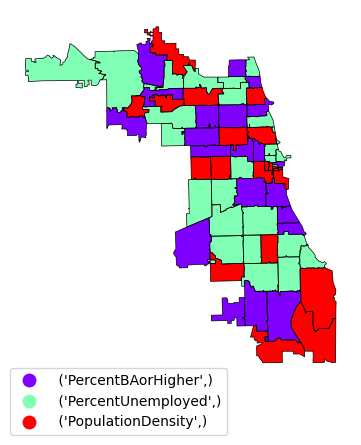

In [57]:
cmap = pl.cm.get_cmap('rainbow')

k = len(np.unique(labels))

norm = plt.Normalize(vmin=0, vmax=k-1)

gdf.plot(column='label', legend=True, categorical=True, cmap=cmap, legend_kwds={'loc': (0, -0.15)})
gdf.boundary.plot(color='k', linewidth=0.5, ax=plt.gca())
plt.axis('off') 
plt.savefig('Chicago_census_GCT_choropleth_k5.svg', bbox_inches='tight')
plt.show()

In [58]:
important_feature_set

{0: (3,), 1: (2,), 2: (0,)}

In [59]:
x_vars

['PopulationDensity',
 'MedianAge',
 'PercentBAorHigher',
 'PercentUnemployed',
 'PercentWhite']

In [60]:
{k: [x_vars[i] for i in v] for k, v in important_feature_set.items()}

{0: ['PercentUnemployed'], 1: ['PercentBAorHigher'], 2: ['PopulationDensity']}

In [61]:
chicago_zipcodes = zip_codes[chicago_mask]
chicago_zipcodes

array([60007, 60018, 60068, 60131, 60176, 60601, 60602, 60603, 60604,
       60605, 60606, 60607, 60608, 60609, 60610, 60611, 60612, 60613,
       60614, 60615, 60616, 60617, 60618, 60619, 60620, 60621, 60622,
       60623, 60624, 60625, 60626, 60628, 60629, 60630, 60631, 60632,
       60633, 60634, 60636, 60637, 60638, 60639, 60640, 60641, 60642,
       60643, 60644, 60645, 60646, 60647, 60649, 60651, 60652, 60653,
       60654, 60655, 60656, 60657, 60659, 60660, 60661, 60706, 60707,
       60714, 60804, 60827])

## Clusters

In [62]:
j = 0
arr = ts_arr[:, labels==j, :].copy()

lrs = np.array([get_likelihoods(arr[:, [i], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])
max_lr_idx = np.argmax(lrs.flatten())
zc = zip_codes[chicago_mask][labels == j][max_lr_idx]
print(zc)

get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[1]

# first feature is the feature of interest, target and intercept are last

60609


array([-0.99805895,  0.38852828,  0.26336925])

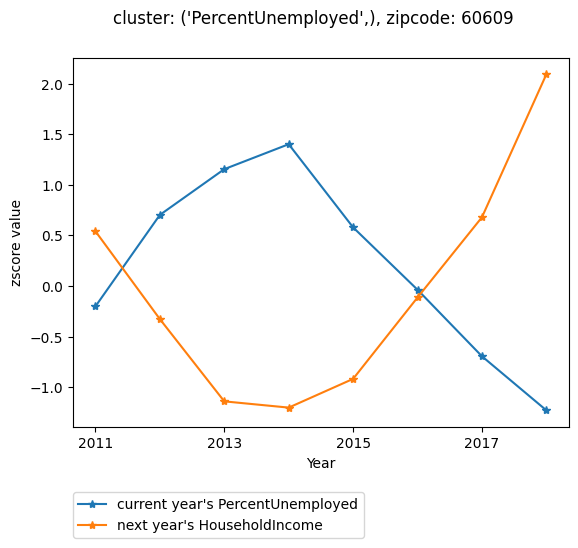

In [63]:
var_idx = important_feature_set[j]

if len(var_idx) > 1:
    fig = plt.figure(figsize=(12, 4))
    
x_year = np.arange(2011, 2019).astype(int)

for f in range(len(var_idx)):
    plt.subplot(1, len(var_idx), f+1)
    plt.plot(x_year, ts_arr[:-1, chicago_zipcodes == zc, var_idx[f]].flatten(), label=f"current year's {x_vars[var_idx[f]]}", marker='*')
    plt.plot(x_year, ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label=f"next year's {y_var[0]}", marker='*')
    plt.ylabel("zscore value")
    plt.xlabel('Year')
    plt.xticks(x_year[::2], x_year[::2])

    plt.legend(loc=(0, -0.3))

plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()


In [64]:
zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

if len(var_idx) == 1:
    coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

    print(f"Test Statistic: {coint_t}")
    print(f"P-value: {p_value}")
    print(f"Critical Values: {critical_values}")

else:
        
    result = coint_johansen(zip_code_ts_arr[:, 0, list(var_idx)+[-1]], det_order=0, k_ar_diff=0)
        
    # Check the trace statistic against critical values
    for i, trace_stat in enumerate(result.lr1):
        critical_value_90 = result.cvt[i, 0]  # 90% critical value
        
        # If trace statistic is greater than the 90% critical value, print the critical values
        if trace_stat > critical_value_90:
            print(f"Rank {i}: Trace statistic ({trace_stat}) > 90% critical value ({critical_value_90})")
            print("Cointegrating relationship exists!")
            print(f"Critical values (90%, 95%, 99%): {result.cvt[i]}")

            break

    else:
        print("Not cointegrating")

Test Statistic: -1.4938144794125137
P-value: 0.763556308220112
Critical Values: [-6.14522163 -4.34824633 -3.70584592]


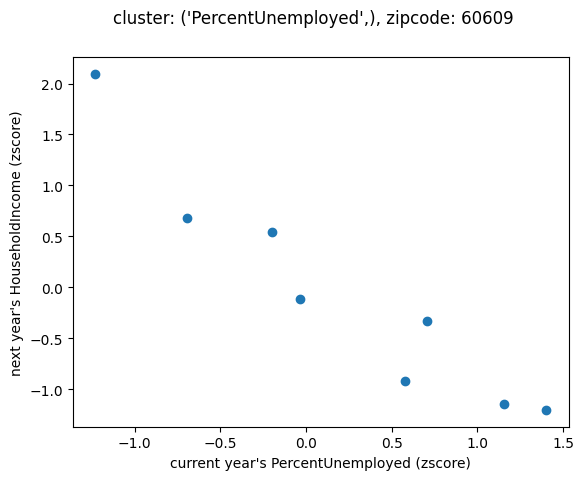

In [65]:

if len(var_idx) > 1:
    fig = plt.figure(figsize=(12, 4))
for f in range(len(var_idx)):
    plt.subplot(1, len(var_idx), f+1)
    plt.scatter(zip_code_ts_arr[:-1, 0, var_idx[f]], zip_code_ts_arr[1:, 0, -1])
    plt.xlabel(f"current year's {x_vars[var_idx[f]]} (zscore)")

    if f == 0:
        plt.ylabel(f"next year's {y_var[0]} (zscore)")

plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
# plt.savefig(f'BP_cluster_{j}.svg', bbox_inches='tight')
plt.show()

In [66]:
j = 1
arr = ts_arr[:, labels==j, :].copy()

lrs = np.array([get_likelihoods(arr[:, [i], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])
max_lr_idx = np.argmax(lrs.flatten())
zc = zip_codes[chicago_mask][labels == j][max_lr_idx]
print(zc)
get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[1]

# first feature is the feature of interest, target and intercept are last

60639


array([0.60259098, 0.75308658, 0.38301101])

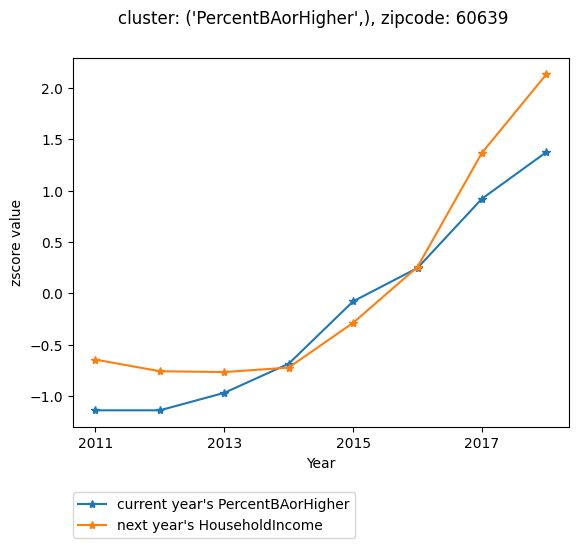

In [67]:
var_idx = important_feature_set[j]

if len(var_idx) > 1:
    fig = plt.figure(figsize=(12, 4))
    
x_year = np.arange(2011, 2019).astype(int)

for f in range(len(var_idx)):
    plt.subplot(1, len(var_idx), f+1)
    plt.plot(x_year, ts_arr[:-1, chicago_zipcodes == zc, var_idx[f]].flatten(), label=f"current year's {x_vars[var_idx[f]]}", marker='*')
    plt.plot(x_year, ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label=f"next year's {y_var[0]}", marker='*')
    plt.ylabel("zscore value")
    plt.xlabel('Year')
    plt.xticks(x_year[::2], x_year[::2])

    plt.legend(loc=(0, -0.3))

plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()


In [68]:
zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

if len(var_idx) == 1:
    coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

    print(f"Test Statistic: {coint_t}")
    print(f"P-value: {p_value}")
    print(f"Critical Values: {critical_values}")

else:
        
    result = coint_johansen(zip_code_ts_arr[:, 0, list(var_idx)+[-1]], det_order=0, k_ar_diff=0)
        
    # Check the trace statistic against critical values
    for i, trace_stat in enumerate(result.lr1):
        critical_value_90 = result.cvt[i, 0]  # 90% critical value
        
        # If trace statistic is greater than the 90% critical value, print the critical values
        if trace_stat > critical_value_90:
            print(f"Rank {i}: Trace statistic ({trace_stat}) > 90% critical value ({critical_value_90})")
            print("Cointegrating relationship exists!")
            print(f"Critical values (90%, 95%, 99%): {result.cvt[i]}")

            break

    else:
        print("Not cointegrating")

Test Statistic: -4.368087618966349
P-value: 0.002000658367243182
Critical Values: [-6.14522163 -4.34824633 -3.70584592]


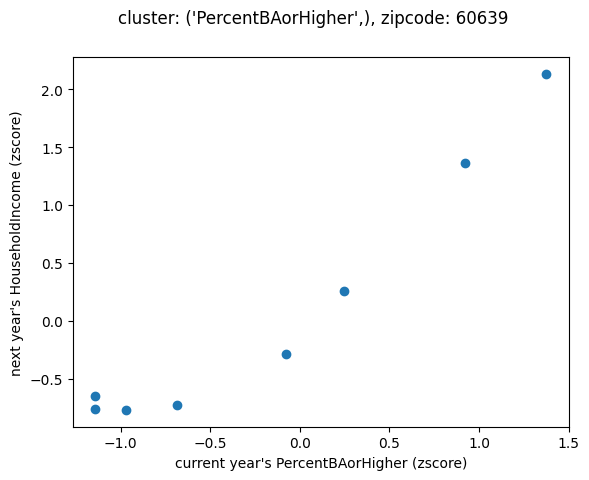

In [69]:

if len(var_idx) > 1:
    fig = plt.figure(figsize=(12, 4))
for f in range(len(var_idx)):
    plt.subplot(1, len(var_idx), f+1)
    plt.scatter(zip_code_ts_arr[:-1, 0, var_idx[f]], zip_code_ts_arr[1:, 0, -1])
    plt.xlabel(f"current year's {x_vars[var_idx[f]]} (zscore)")

    if f == 0:
        plt.ylabel(f"next year's {y_var[0]} (zscore)")

plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
# plt.savefig(f'BP_cluster_{j}.svg', bbox_inches='tight')
plt.show()

In [70]:
j = 2
arr = ts_arr[:, labels==j, :].copy()

lrs = np.array([get_likelihoods(arr[:, [i], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])
max_lr_idx = np.argmax(lrs.flatten())
zc = zip_codes[chicago_mask][labels == j][max_lr_idx]
print(zc)
get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[1]

# first feature is the feature of interest, target and intercept are last

60633


array([-0.9699364 ,  0.03490498,  0.24041478])

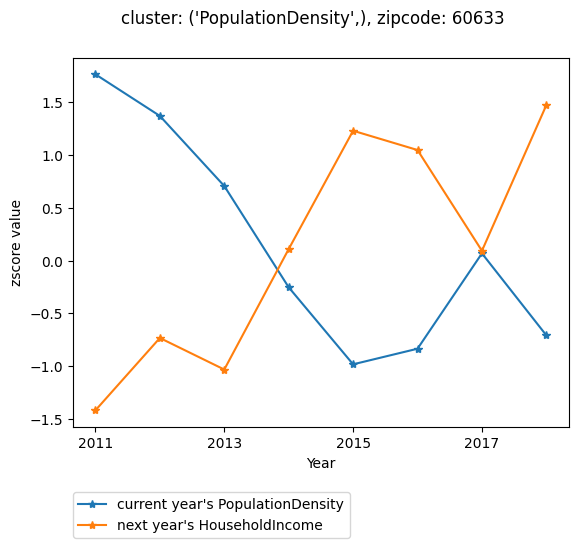

In [71]:
var_idx = important_feature_set[j]

if len(var_idx) > 1:
    fig = plt.figure(figsize=(12, 4))
    
x_year = np.arange(2011, 2019).astype(int)

for f in range(len(var_idx)):
    plt.subplot(1, len(var_idx), f+1)
    plt.plot(x_year, ts_arr[:-1, chicago_zipcodes == zc, var_idx[f]].flatten(), label=f"current year's {x_vars[var_idx[f]]}", marker='*')
    plt.plot(x_year, ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label=f"next year's {y_var[0]}", marker='*')
    plt.ylabel("zscore value")
    plt.xlabel('Year')
    plt.xticks(x_year[::2], x_year[::2])

    plt.legend(loc=(0, -0.3))

plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()


In [72]:
zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]

if len(var_idx) == 1:
    coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

    print(f"Test Statistic: {coint_t}")
    print(f"P-value: {p_value}")
    print(f"Critical Values: {critical_values}")

else:
        
    result = coint_johansen(zip_code_ts_arr[:, 0, list(var_idx)+[-1]], det_order=0, k_ar_diff=0)
        
    # Check the trace statistic against critical values
    for i, trace_stat in enumerate(result.lr1):
        critical_value_90 = result.cvt[i, 0]  # 90% critical value
        
        # If trace statistic is greater than the 90% critical value, print the critical values
        if trace_stat > critical_value_90:
            print(f"Rank {i}: Trace statistic ({trace_stat}) > 90% critical value ({critical_value_90})")
            print("Cointegrating relationship exists!")
            print(f"Critical values (90%, 95%, 99%): {result.cvt[i]}")

            break

    else:
        print("Not cointegrating")

Test Statistic: -1.9507163775291538
P-value: 0.5540817616576513
Critical Values: [-6.14522163 -4.34824633 -3.70584592]


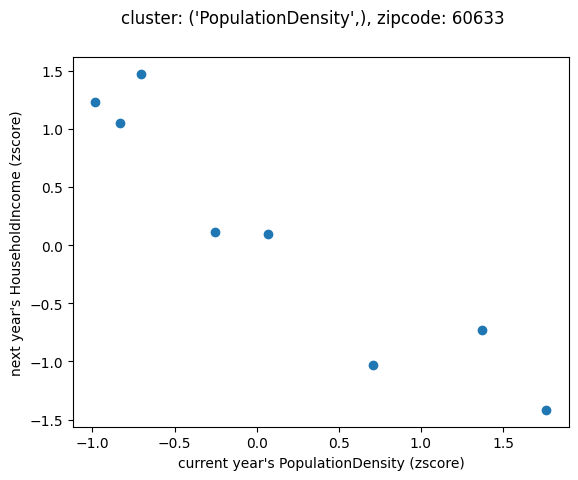

In [73]:

if len(var_idx) > 1:
    fig = plt.figure(figsize=(12, 4))
for f in range(len(var_idx)):
    plt.subplot(1, len(var_idx), f+1)
    plt.scatter(zip_code_ts_arr[:-1, 0, var_idx[f]], zip_code_ts_arr[1:, 0, -1])
    plt.xlabel(f"current year's {x_vars[var_idx[f]]} (zscore)")

    if f == 0:
        plt.ylabel(f"next year's {y_var[0]} (zscore)")

plt.suptitle(f"cluster: {tuple([x_vars[f] for f in var_idx])}, zipcode: {zc}")
# plt.savefig(f'BP_cluster_{j}.svg', bbox_inches='tight')
plt.show()

In [ ]:
j = 3
arr = ts_arr[:, labels==j, :].copy()

lrs = np.array([get_likelihoods(arr[:, [i], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])
max_lr_idx = np.argmax(lrs.flatten())
zc = zip_codes[chicago_mask][labels == j][max_lr_idx]
print(zc)
get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[1]

# first feature is the feature of interest, target and intercept are last

In [ ]:
var_idx = important_feature_set[j][0] if len(important_feature_set[j]) == 1 else None
# zc = 60636
plt.plot(np.arange(2011, 2019), ts_arr[:-1, chicago_zipcodes == zc, var_idx].flatten(), label=f"current year's {x_vars[var_idx]}", marker='*')
plt.plot(np.arange(2011, 2019), ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label="next year's median income", marker='*')
plt.ylabel("zscore value")
plt.xlabel('Year')
plt.legend()
plt.title(f"cluster: {var_idx}, zipcode: {zc}")
plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()

In [ ]:
zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]
coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

print(f"Test Statistic: {coint_t}")
print(f"P-value: {p_value}")
print(f"Critical Values: {critical_values}")

In [ ]:
plt.scatter(zip_code_ts_arr[:-1, 0, var_idx], zip_code_ts_arr[1:, 0, -1])
plt.xlabel(f"current year's {x_vars[var_idx]} (zscore)")
plt.ylabel("next year's median income (zscore)")
plt.title(f"cluster: {var_idx}, zipcode: {zc}")
# plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()

In [ ]:
j = 4
arr = ts_arr[:, labels==j, :].copy()

lrs = np.array([get_likelihoods(arr[:, [i], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[0] for i in range(arr.shape[1])])
max_lr_idx = np.argmax(lrs.flatten())
zc = zip_codes[chicago_mask][labels == j][max_lr_idx]
print(zc)
get_likelihoods(arr[:, [max_lr_idx], :], {0: important_feature_set[j]}, maxlag=1, fit_intercept=True, lambda_reg=0, which='unrestricted', return_thetas=True)[1]

# first feature is the feature of interest, target and intercept are last

In [ ]:
var_idx = important_feature_set[j][0] if len(important_feature_set[j]) == 1 else None
# zc = 60636

# fig = plt.figure(figsize=(15, 4))

# plt.subplot(121)
plt.plot(np.arange(2011, 2019), ts_arr[:-1, chicago_zipcodes == zc, var_idx].flatten(), label=f"current year's {x_vars[var_idx]}", marker='*')
plt.plot(np.arange(2011, 2019), ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label="next year's median income", marker='*')
plt.ylabel("zscore value")
plt.xlabel('Year')
plt.legend()

# var_idx = 4
# plt.subplot(122)
# plt.plot(np.arange(2012, 2019), ts_arr[:-1, chicago_zipcodes == zc, var_idx].flatten(), label=f"current year's {x_vars[var_idx]}", marker='*')
# plt.plot(np.arange(2012, 2019), ts_arr[1:, chicago_zipcodes == zc, -1].flatten(), label="next year's median income", marker='*')
# plt.ylabel("change in zscore value")
# plt.xlabel('Year')
# plt.legend()

plt.title(f"cluster: {var_idx}, zipcode: {zc}")
plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()

In [ ]:
zip_code_ts_arr = ts_arr[:, chicago_zipcodes == zc, :]
coint_t, p_value, critical_values = coint(zip_code_ts_arr[1:, 0, -1], zip_code_ts_arr[:-1, 0, var_idx], trend='c', maxlag=1, autolag=None)

print(f"Test Statistic: {coint_t}")
print(f"P-value: {p_value}")
print(f"Critical Values: {critical_values}")

In [ ]:
plt.scatter(zip_code_ts_arr[:-1, 0, var_idx], zip_code_ts_arr[1:, 0, -1])
plt.xlabel(f"current year's {x_vars[var_idx]} (zscore)")
plt.ylabel("next year's median income (zscore)")
plt.title(f"cluster: {var_idx}, zipcode: {zc}")
# plt.savefig(f'Census_cluster_{j}.svg', bbox_inches='tight')
plt.show()

# End Chicago

In [ ]:
print_model(theta_u, vars=vars, maxlag=maxlag, sort_by_weights=True, fit_intercept=fit_intercept)

In [ ]:
def get_pred(X, theta_us, labels, maxlag, fit_intercept, y_col_idx=-1):
    N = X.shape[1]
    K = len(np.unique(labels))

    arr = []

    for i in np.arange(N):
        Xi = X[:, i, :]
        Xi_u, _, _ = create_design_data(Xi, maxlag=maxlag, y_col_idx=y_col_idx, fit_intercept=fit_intercept)

        y_pred = np.matmul(Xi_u, theta_us[labels[i]])

        arr.append(y_pred.flatten())

    return np.array(arr)

In [ ]:
# u_ptsc_pred = get_pred(ts_arr, theta_u, labels, maxlag, fit_intercept)
# u_ptsc_pred.shape

In [ ]:
# g_ptsc_pred = get_pred(ts_arr, theta_u, labels, maxlag, fit_intercept)
# g_ptsc_pred.shape

In [ ]:
zip_codes_down_town_chicago = [60601, 60602, 60603, 60604, 60605, 60606, 60607, 60610, 60611, 60613, 60614, 60616, 60654, 60661]
fig = plt.figure(figsize=(15, 15))

for i in range(len(zip_codes_down_town_chicago)):
    zip_i = zip_codes_down_town_chicago[i]
    idx = np.arange(len(zip_codes))[zip_codes == zip_i]
    arr = ts_arr[:, idx, :]
    # fig, axes = tsp.plot(X=arr[:, :, [-1]], show_X_marker=True, title_list=y_var)
    axes = [fig.add_subplot(5, 3, i+1)]

    axes[-1].scatter(np.arange(1, arr.shape[0]), arr[1:, 0, [-1]])

    ma = arr[:, 0, :].cumsum(axis=0) / np.arange(1, arr.shape[0]+1).reshape(-1, 1)



    # for f in range(arr.shape[-1]):
    #     # axes[f].plot(ma[:, f], label='MA')
    #     # axes[f].plot(arr[1:, 0, f], label='y_future', marker='*')
    #     ma = pd.Series(arr[:, 0, f]).expanding().mean()
    #     axes[f].plot(ma.values, label='MA')

    #     axes[f].legend()

    axes[-1].plot(np.arange(arr.shape[0])[-u_ptsc_pred.shape[1]:], u_ptsc_pred[idx].flatten(), label='U_PTSC_pred', color='r', marker='.')
    axes[-1].plot(np.arange(arr.shape[0])[-g_ptsc_pred.shape[1]:], g_ptsc_pred[idx].flatten(), label='G_PTSC_pred', color='g', marker='.')

    # axes[-1].plot(np.arange(arr.shape[0])[-u_ptsc_pred.shape[1]:], u_ptsc_pred[idx].flatten().cumsum() / u_ptsc_pred.shape[1], color='r', ls='--', 
    #               label='MA_U_PTSC_pred')
    # axes[-1].plot(np.arange(arr.shape[0])[-g_ptsc_pred.shape[1]:], g_ptsc_pred[idx].flatten().cumsum() / u_ptsc_pred.shape[1], color='g', ls='--',
    #                label='MA_G_PTSC_pred')
    axes[-1].set_title(str(zip_i))

    plt.legend()

plt.show()


In [ ]:
## U-PTSC

k = 3

idx_mask = zip_codes == 60661 #labels == k

fig = plt.figure(figsize=(15, 12))

coef = list(theta_u[k][1:].flatten()) + list(theta_u[k][0].flatten())

nrows, ncols = 3, 2

for f in range(ts_arr.shape[-1]):
    ax = fig.add_subplot(nrows, ncols, f+1)
    ax.scatter(ts_arr[:-1, idx_mask, f], ts_arr[1:, idx_mask, -1], label='data')
    # ax.scatter(ts_arr[:-1, idx_mask, f], u_ptsc_pred[idx_mask, :])
    ax.plot(ts_arr[:-1, idx_mask, f].flatten(), ts_arr[:-1, idx_mask, f].flatten() * coef[f], color='r', label='coef')
    
    ax.set_xlabel(f"current year's {(x_vars + y_var)[f]}")

    if f % ncols == 0:
        ax.set_ylabel("next year's median income")

    ax.legend()

plt.show()

In [ ]:
## G-PTSC

k = 0

idx_mask = zip_codes == 60661 #labels == k

fig = plt.figure(figsize=(15, 12))

coef = list(theta_u[k][1:].flatten()) + list(theta_u[k][0].flatten())

nrows, ncols = 3, 2

for f in range(ts_arr.shape[-1]):
    ax = fig.add_subplot(nrows, ncols, f+1)
    ax.scatter(ts_arr[:-1, idx_mask, f], ts_arr[1:, idx_mask, -1], label='data')
    # ax.scatter(ts_arr[:-1, idx_mask, f], u_ptsc_pred[idx_mask, :])
    ax.plot(ts_arr[:-1, idx_mask, f].flatten(), ts_arr[:-1, idx_mask, f].flatten() * coef[f], color='r', label='coef')
    
    ax.set_xlabel(f"current year's {(x_vars + y_var)[f]}")

    if f % ncols == 0:
        ax.set_ylabel("next year's median income")

    ax.legend()

plt.show()

END

In [ ]:
k = 0
gdf_ = gdf[gdf['label'] == f'Cluster {k}'].reset_index()
gdf_['zip_code'] = gdf_['zip_code'].astype(str)
gdf_['zip_code'] = gdf_['zip_code'][gdf_['zip_code'] == '60661']
gdf_.plot(column='zip_code', legend=True, legend_kwds={'loc': (1.01, 0)}
                                          )
gdf.boundary.plot(color='k', linewidth=0.5, ax=plt.gca())
plt.axis('off')
plt.show()


In [ ]:
label_dict = {
    'T': years,
    'F': vars
}
tsp.waterfall_plot(ts_arr[:, np.argmax(ctuids==60646), :], label_dict=label_dict);

In [ ]:
tsp.plot(X=ts_arr[:, :, :], label_dict=label_dict, entity_idx=[np.argmax(ctuids==60646)], entities_labels=['60646'],
         show_all_entities=False, shape_of_subplot=(3, 2), figsize=(10, 8), annot_fontsize=10)
plt.show()

In [ ]:
k = 2
gdf[gdf['label'] == k].plot(column='zipcode', legend=True, legend_kwds={'loc': (1.01, 0)})
gdf[gdf['label'] == k].boundary.plot(color='k', linewidth=0.5, ax=plt.gca())
plt.axis('off')
plt.show()


TotalPopulation

In [ ]:

var = 'TotalPopulation'

fig = plt.figure(figsize=(12, 4))

for i in range(len(years)):
    ax = fig.add_subplot(3, 3, i+1)
    gdf.plot(column=var+"_"+years[i], ax=ax, legend=True, cmap='rainbow')

    plt.title(f"year '{years[i]}")
    plt.axis('off') 

plt.suptitle(f"change in {var}")
plt.savefig('Toronto_census_popdens_choropleth_k6.svg', bbox_inches='tight')

plt.show()

MedianAge(years)

In [ ]:
var = 'MedianAge(years)'

fig = plt.figure(figsize=(12, 4))

for i in range(len(years)):
    ax = fig.add_subplot(3, 3, i+1)
    gdf.plot(column=var+"_"+years[i], ax=ax, legend=True, cmap='rainbow')

    plt.title(f"year '{years[i]}")
    plt.axis('off') 

plt.suptitle(f"change in {var}")
plt.savefig('Toronto_census_dwhirise_choropleth_k6.svg', bbox_inches='tight')

plt.show()

PercentBAOrHigher

In [ ]:
var = 'PercentBAOrHigher'

fig = plt.figure(figsize=(12, 4))

for i in range(len(years)):
    ax = fig.add_subplot(3, 3, i+1)
    gdf.plot(column=var+"_"+years[i], ax=ax, legend=True, cmap='rainbow')

    plt.title(f"year '{years[i]}")
    plt.axis('off') 

plt.suptitle(f"change in {var}")
plt.savefig('Toronto_census_ageyouth_choropleth_k6.svg', bbox_inches='tight')

plt.show()

PercentUnemployed

In [ ]:
var = 'PercentUnemployed'

fig = plt.figure(figsize=(12, 4))

for i in range(len(years)):
    ax = fig.add_subplot(3, 3, i+1)
    gdf.plot(column=var+"_"+years[i], ax=ax, legend=True, cmap='rainbow')

    plt.title(f"year '{years[i]}")
    plt.axis('off') 

plt.suptitle(f"change in {var}")
plt.savefig('Toronto_census_vmblack_choropleth_k6.svg', bbox_inches='tight')

plt.show()

HouseholdIncome

In [ ]:
var = 'HouseholdIncome'

fig = plt.figure(figsize=(12, 4))

for i in range(len(years)):
    ax = fig.add_subplot(3, 3, i+1)
    gdf.plot(column=var+"_"+years[i], ax=ax, legend=True, cmap='rainbow')

    plt.title(f"year '{years[i]}")
    plt.axis('off') 

plt.suptitle(f"change in {var}")
plt.savefig('Toronto_census_unemp_choropleth_k6.svg', bbox_inches='tight')

plt.show()

# End